In [1]:
from skimage.io import imread_collection, imread
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
os.environ["THEANO_FLAGS"] = "device=gpu"
sys.path.append(os.getcwd()+"/..")

In [2]:
from lasagnekit.easy import layers_from_list_to_dict
from lasagne import layers, init
from lasagne.nonlinearities import rectify, linear
from lasagnekit.easy import iterate_minibatches
def build_model(nb_filters=64, w=32, h=32, cin=3, cout=1, filter_size=3, nb_layers=3):
    """
    Pyramidal auto-encoder input-input
    """
    if type(filter_size) == int:
        filter_size = [filter_size] * (nb_layers + 1)
    l_in = layers.InputLayer((None, cin, w, h), name="input")
    l_conv = l_in
    for i in range(nb_layers):
        l_conv = layers.Conv2DLayer(
            l_conv,
            num_filters=nb_filters,
            filter_size=(filter_size[i], filter_size[i]),
            pad='same', 
            nonlinearity=rectify,
            W=init.GlorotUniform(),
        )
    l_output = layers.Conv2DLayer(
        l_conv,
        num_filters=cout,
        filter_size=(filter_size[-1], filter_size[-1]),
        pad='same',
        nonlinearity=linear,
        W=init.GlorotUniform(),
        name="output"
    )
    return layers_from_list_to_dict([l_in, l_output])

Using gpu device 0: Tesla K20Xm (CNMeM is disabled, CuDNN 3007)
/home/mcherti/work/code/scikit-learn/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.19.
  "This module will be removed in 0.19.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
photos = glob.glob('/home/mcherti/work/data/facesketch/photos/*.jpg')
sketches = [photo.replace('photos', 'sketches') for photo in photos]

In [5]:
X = []
Y = []
for photo, sketch in zip(photos, sketches):
    try:
        imgphoto = imread(photo)
        imgsketch = imread(sketch)
    except Exception:
        continue
    else:
        X.append(imgphoto)
        if len(imgsketch.shape) == 3:
            imgsketch = imgsketch[:, :, 0]
        Y.append(imgsketch)

Xtrain = np.array(X) / 255.
Ytrain = np.array(Y) / 255.

Ytrain = Ytrain[:, :, :, None]
Xtrain = Xtrain.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)

Xtrain = Xtrain.transpose((0, 3, 1, 2))
Ytrain = Ytrain.transpose((0, 3, 1, 2))


In [76]:
all_layers = build_model(nb_filters=64, w=None, h=None, filter_size=3, nb_layers=8)

In [77]:
import theano.tensor as T
import theano
from lasagne import layers

X = T.tensor4()
Y = T.tensor4()

Y_pred = (layers.get_output(all_layers['output'], X))
loss = ((Y_pred - Y) ** 2).mean()

In [78]:
from lasagne import updates
import numpy as np
params = layers.get_all_params(all_layers.values(), trainable=True)
print("Number of params : {}".format(layers.count_params(all_layers.values(), trainable=True))) 
lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
params_updates = updates.adam(loss, params, learning_rate=lr)

Number of params : 260865


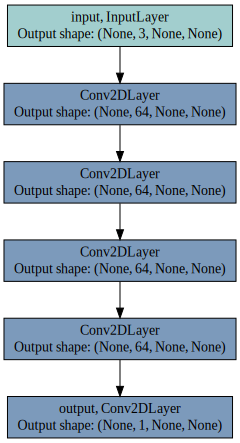

In [53]:
from lasagnekit.misc.draw_net import draw_to_file
from IPython.display import SVG
draw_to_file(layers.get_all_layers(all_layers['output']), 'out.svg')
SVG('out.svg')

In [79]:
train_fn = theano.function([X, Y], loss, updates=params_updates, on_unused_input='warn')

In [80]:
predict_fn = theano.function([X], Y_pred, on_unused_input='warn')

In [81]:
from time import time, sleep
a = 0.001
lr.set_value(a)
train_loss = []
test_loss = []

In [82]:
nb_epochs = 100
nb_training_data = Xtrain.shape[0]
batch_size = 32
nb_updates_per_epoch = nb_training_data / batch_size
if (nb_training_data % batch_size) > 0:
    nb_updates_per_epoch += 1
nb_updates = nb_epochs * nb_updates_per_epoch

In [83]:
start = time()
for epoch in range(nb_epochs):
    total_loss = 0.
    nb = 0
    for mini_batch in iterate_minibatches(len(Xtrain), batch_size):
        loss_val = train_fn(Xtrain[mini_batch], Ytrain[mini_batch])
        total_loss += loss_val
        nb += 1
    total_loss /= nb
    train_loss.append(total_loss)
    print('train_loss : {}'.format(total_loss))

MemoryError: Error allocating 409600000 bytes of device memory (out of memory).
Apply node that caused the error: GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))},no_inplace}(CudaNdarrayConstant{[[[[ 0.5]]]]}, GpuElemwise{Add}[(0, 0)].0)
Toposort index: 219
Inputs types: [CudaNdarrayType(float32, (True, True, True, True)), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1, 1, 1, 1), (32, 64, 250, 200)]
Inputs strides: [(0, 0, 0, 0), (3200000, 50000, 200, 1)]
Inputs values: [CudaNdarray([[[[ 0.5]]]]), 'not shown']
Outputs clients: [[GpuContiguous(GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))},no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

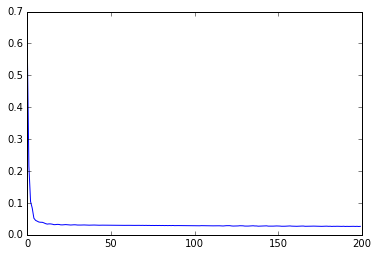

In [71]:
plt.plot(train_loss)

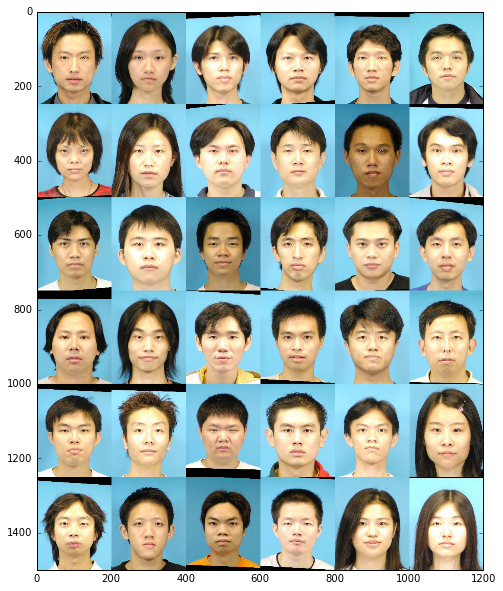

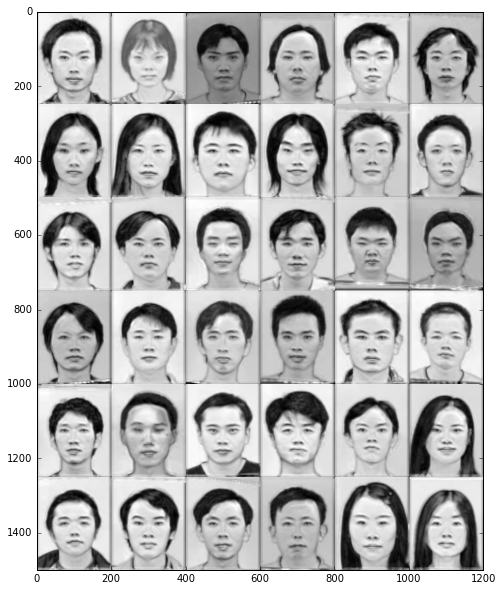

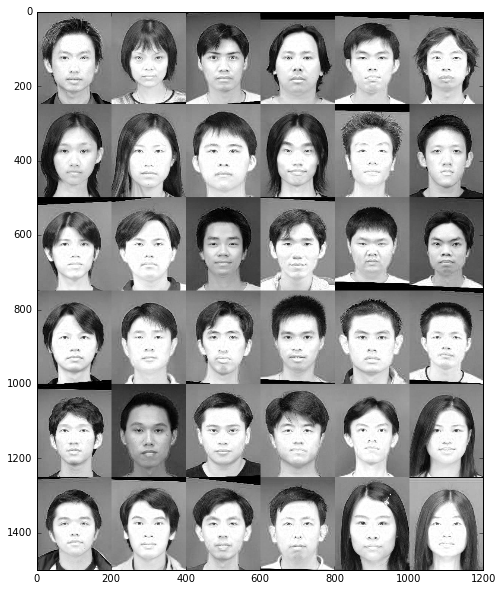

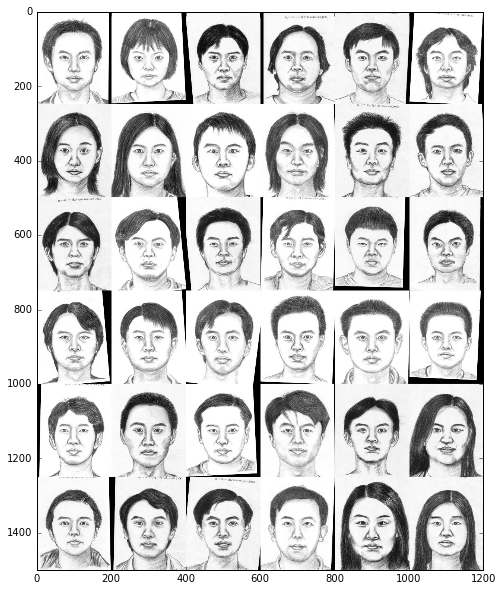

In [72]:
from lasagnekit.misc.plot_weights import tile_raster_images, dispims_color
nb =  36
Xtrain_ = Xtrain[0:nb]
ytrain_ = Ytrain[0:nb]

ypred = predict_fn(Xtrain_)

fig = plt.figure(figsize=(10, 10))

img = dispims_color(Xtrain_.transpose((0, 2, 3, 1)))
plt.imshow(img)
plt.show()

fig = plt.figure(figsize=(10, 10))

img = tile_raster_images(ypred, (250, 200), (6, 6))
plt.imshow(img, cmap='gray')
plt.show()

fig = plt.figure(figsize=(10, 10))

img = tile_raster_images(Xtrain_[:, 0, :, :], (250, 200), (6, 6))
plt.imshow(img, cmap='gray')
plt.show()


fig = plt.figure(figsize=(10, 10))
img = tile_raster_images(ytrain_, (250, 200), (6, 6))
plt.imshow(img, cmap='gray')

(1, 3, 800, 600)


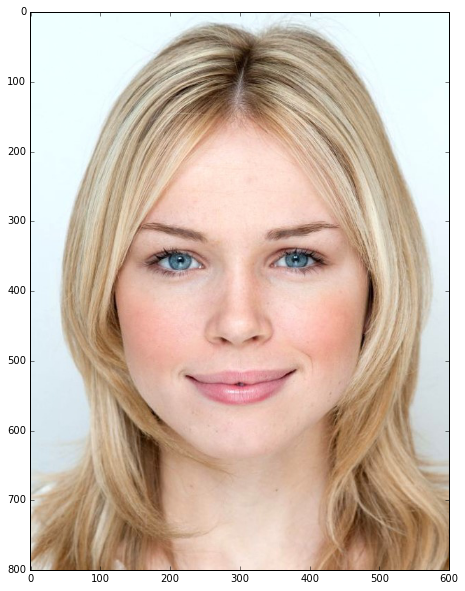

(1, 1, 800, 600)


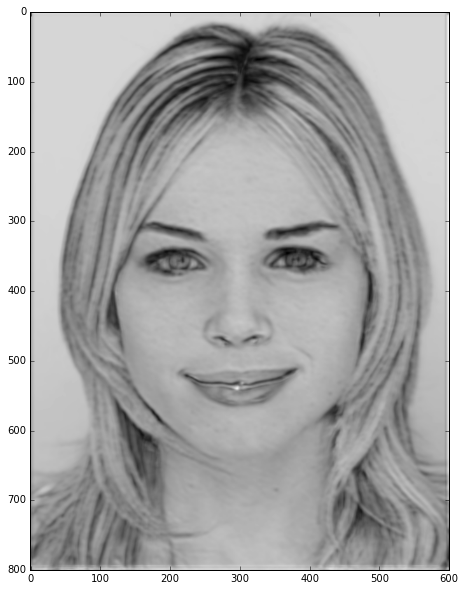

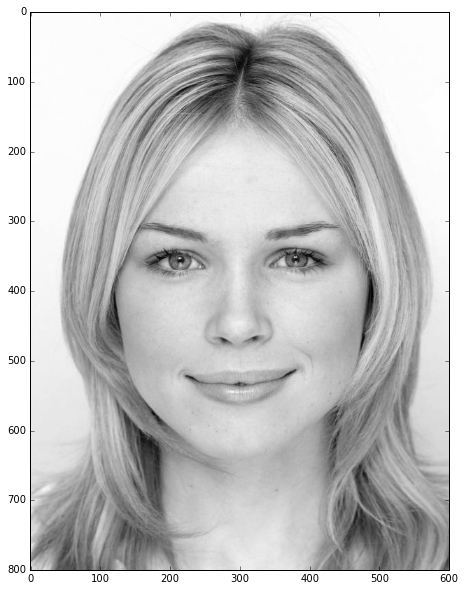

In [73]:
from skimage.io import imread
from skimage.transform import resize
a = imread('photo.jpg')
a = a / 255.
a = a[None, :, :, :]
a = a.astype(np.float32)
a = a.transpose((0, 3, 1, 2))
print(a.shape)

fig = plt.figure(figsize=(10, 10))
plt.imshow(a.transpose((0, 2, 3, 1))[0])
plt.show()
a_pred = predict_fn(a)
print(a_pred.shape)

fig = plt.figure(figsize=(10, 10))
plt.imshow(a_pred[0, 0], cmap='gray')
plt.show()

fig = plt.figure(figsize=(10, 10))
plt.imshow(a[0].mean(axis=0), cmap='gray')
plt.show()